In [ ]:
import numpy as np
import pandas as pd
import os
from zipfile import ZipFile


os.environ['KAGGLE_USERNAME'] = 'Melvern Hidayat'
os.environ['KAGGLE_KEY'] = '5dfce6cfc6d9ac41a9284f61368624c2'


!kaggle datasets download -d dionisiusdh/indonesian-batik-motifs

with ZipFile('indonesian-batik-motifs.zip', 'r') as zip_ref:
    zip_ref.extractall('batik_dataset')


Dataset URL: https://www.kaggle.com/datasets/dionisiusdh/indonesian-batik-motifs
License(s): CC0-1.0
indonesian-batik-motifs.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil


dataset_dir = '/content/batik_dataset'


selected_classes = ['batik-bali', 'batik-betawi', 'batik-celup']


subset_dir = 'batik_choosed'

if not os.path.exists(subset_dir):
    os.makedirs(subset_dir)

# Menyalin gambar dari kelas yang dipilih ke direktori subset
for class_name in selected_classes:
    class_dir = os.path.join(dataset_dir, class_name)
    subset_class_dir = os.path.join(subset_dir, class_name)

    if not os.path.exists(subset_class_dir):
        os.makedirs(subset_class_dir)

    for filename in os.listdir(class_dir):
        src_file = os.path.join(class_dir, filename)
        dst_file = os.path.join(subset_class_dir, filename)
        shutil.copyfile(src_file, dst_file)

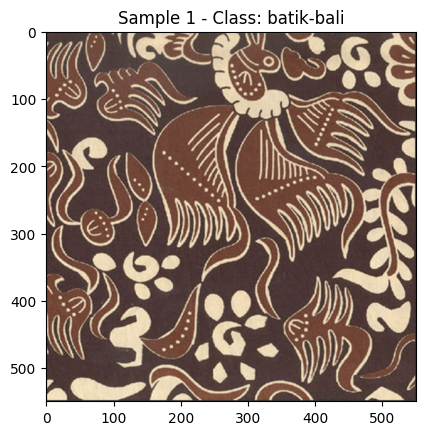

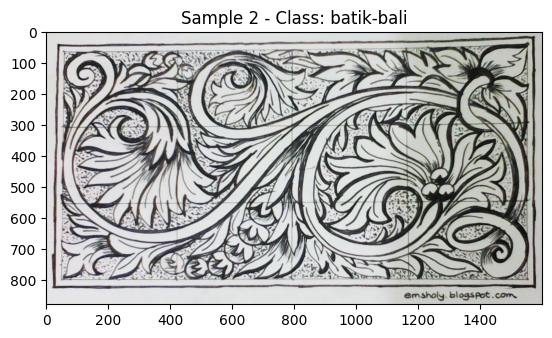

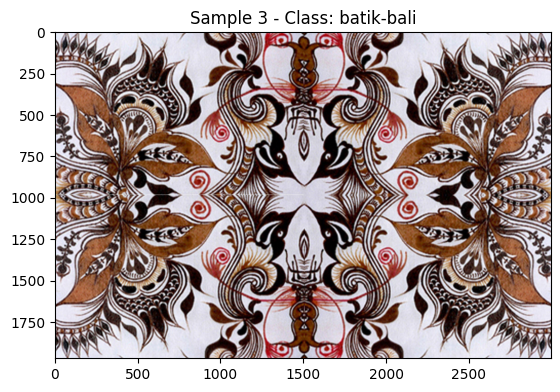

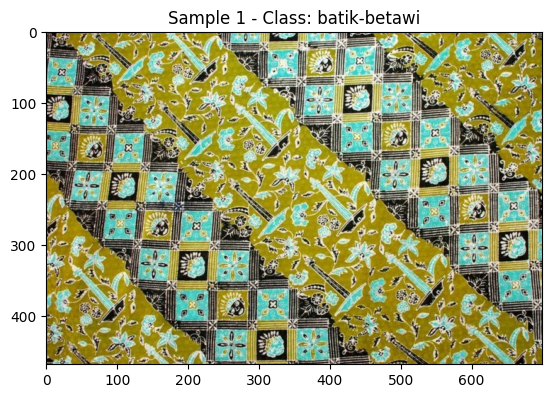

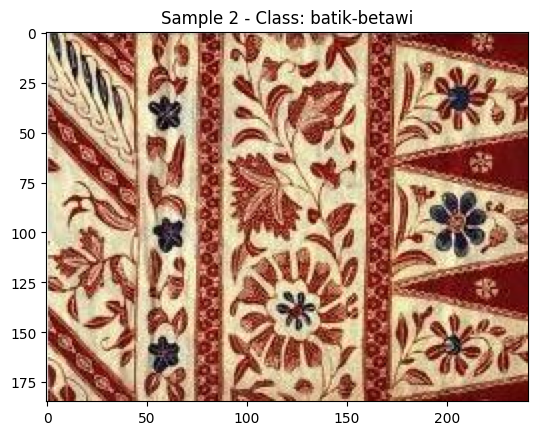

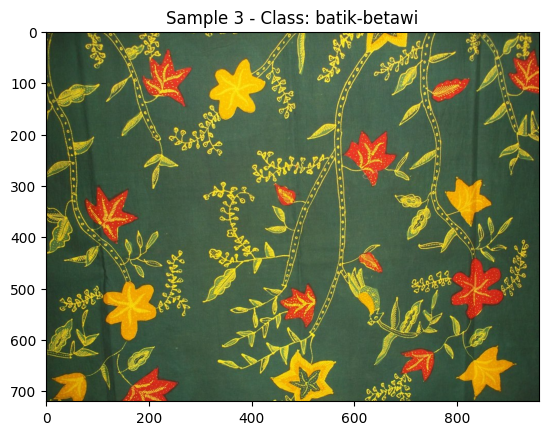

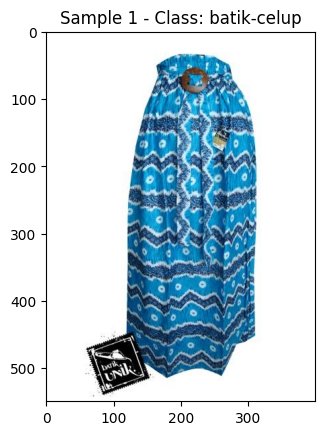

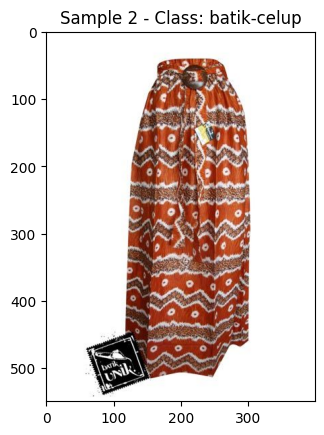

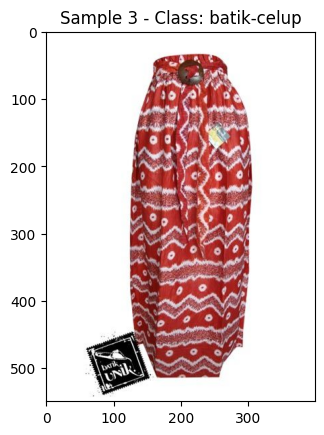

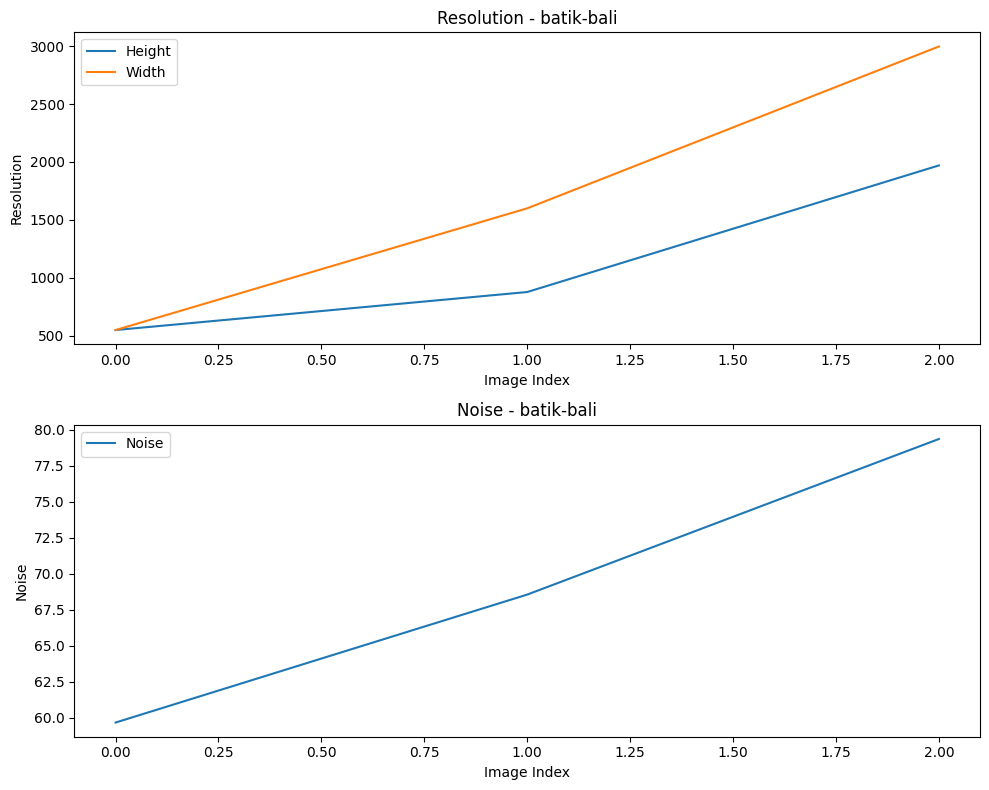

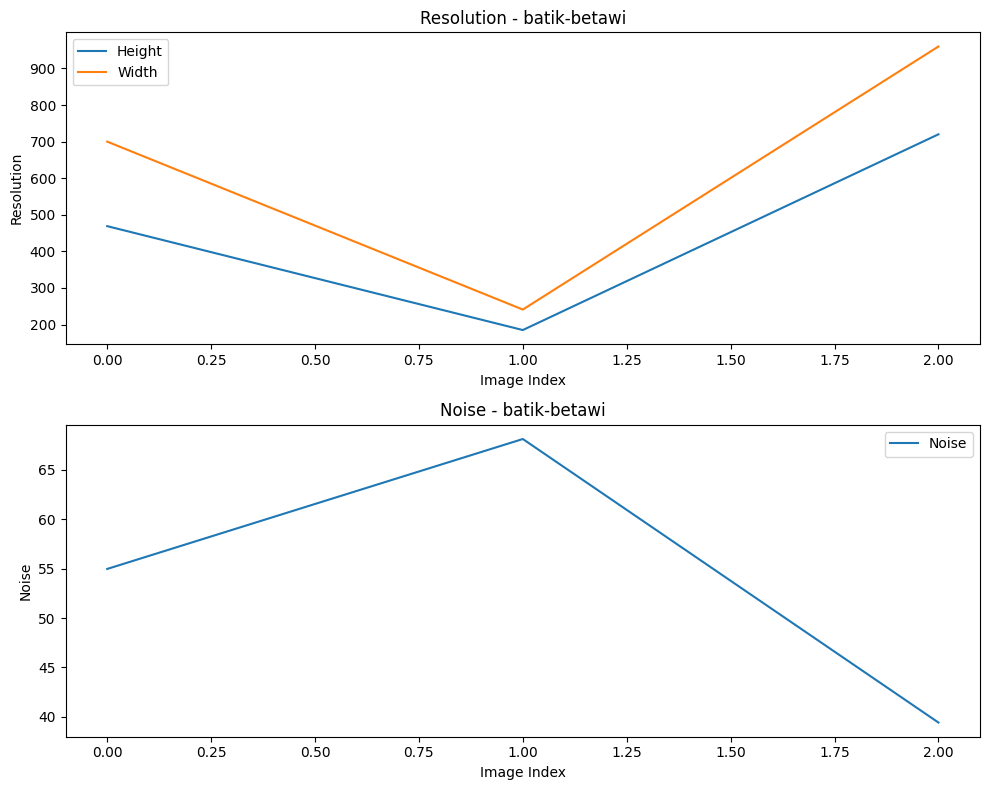

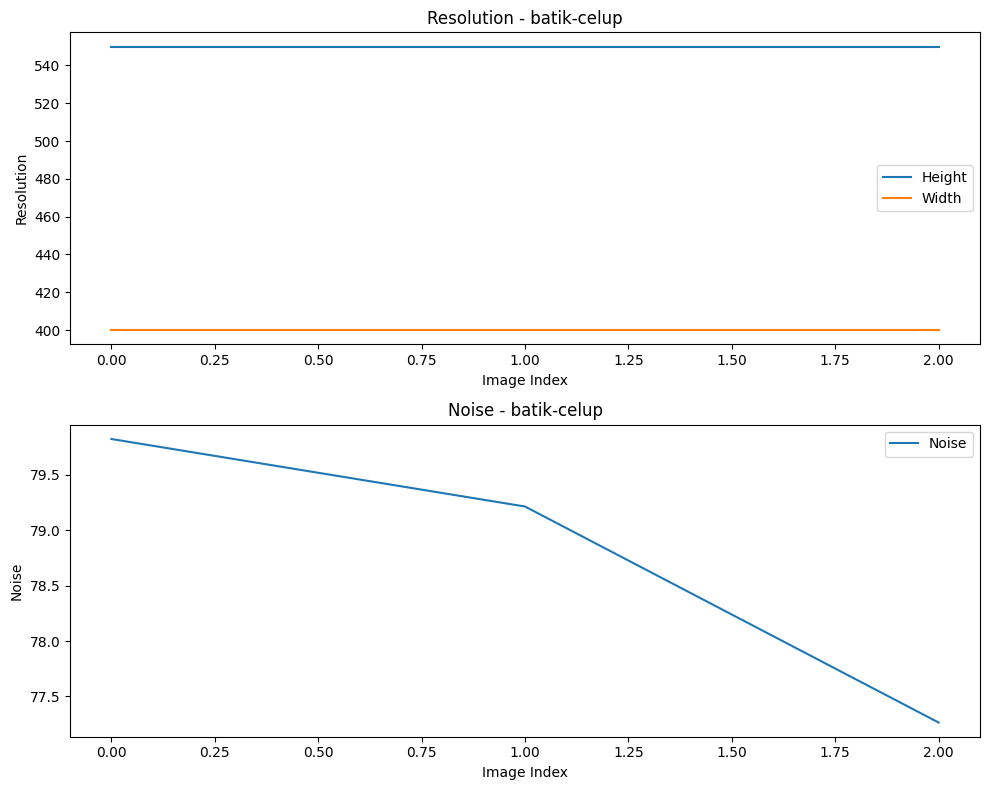

In [ ]:
import cv2
import matplotlib.pyplot as plt
# Fungsi untuk menghitung resolusi dan noise
def calculate_resolution_noise(image_paths):
    resolutions = []
    noises = []

    for image_path in image_paths:
        image = cv2.imread(image_path)
        if image is not None:
            # Calculate resolution
            height, width, _ = image.shape
            resolutions.append((height, width))

            # Calculate noise
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            noise = np.std(gray_image)
            noises.append(noise)

    return resolutions, noises

# Fungsi untuk visualisasi
def visualize_chart(resolutions, noises, label):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Line chart for resolution
    resolutions = np.array(resolutions)
    axes[0].plot(range(len(resolutions)), resolutions[:, 0], label='Height')
    axes[0].plot(range(len(resolutions)), resolutions[:, 1], label='Width')
    axes[0].set_title(f'Resolution - {label}')
    axes[0].set_xlabel('Image Index')
    axes[0].set_ylabel('Resolution')
    axes[0].legend()

    # Line chart for noise
    axes[1].plot(range(len(noises)), noises, label='Noise')
    axes[1].set_title(f'Noise - {label}')
    axes[1].set_xlabel('Image Index')
    axes[1].set_ylabel('Noise')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Fungsi untuk eksplorasi data gambar
def explore_image_data(data_dirs, num_samples=3):
    class_data = {}
    for data_dir in data_dirs:
        class_label = os.path.basename(data_dir)
        class_data[class_label] = {'resolutions': [], 'noises': []}

        image_paths = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir)]

        for image_path in image_paths[:num_samples]:
            image = cv2.imread(image_path)
            if image is not None:
                height, width, _ = image.shape
                noise = np.std(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

                class_data[class_label]['resolutions'].append((height, width))
                class_data[class_label]['noises'].append(noise)

                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.title(f"Sample {len(class_data[class_label]['resolutions'])} - Class: {class_label}")
                plt.show()

    for label, data in class_data.items():
        visualize_chart(data['resolutions'], data['noises'], label)

# Direktori eksplorasi data
explore_data_dirs = [
    os.path.join(subset_dir, 'batik-bali'),
    os.path.join(subset_dir, 'batik-betawi'),
    os.path.join(subset_dir, 'batik-celup')
]

# Eksplorasi data gambar
explore_image_data(explore_data_dirs)


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# Pra-pemrosesan dataset dengan augmentasi
image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    subset_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    subset_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 120 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


In [ ]:
# Model dari Scratch
scratch_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

scratch_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Menampilkan summary model dari scratch
print("Summary Model dari Scratch:")
scratch_model.summary()

Summary Model dari Scratch:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooli

In [ ]:
# Load MobileNetV2 tanpa lapisan atas
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze lapisan-lapisan dari model base

# Menambahkan lapisan atas (top) yang baru
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)

# Menggabungkan model
pretrained_model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

pretrained_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Menampilkan summary model pretrained
print("Summary Model Pretrained (MobileNetV2):")
pretrained_model.summary()


Summary Model Pretrained (MobileNetV2):
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)   

In [ ]:
# Melatih model dari scratch
history_scratch = scratch_model.fit(train_generator,epochs=10,validation_data=validation_generator)

Epoch 1/10
4/4 [==============================] - 36s 10s/step - loss: 2.9689 - accuracy: 0.3083 - val_loss: 1.1644 - val_accuracy: 0.3333
Epoch 2/10
4/4 [==============================] - 19s 4s/step - loss: 1.1354 - accuracy: 0.3750 - val_loss: 1.0848 - val_accuracy: 0.3333
Epoch 3/10
4/4 [==============================] - 16s 4s/step - loss: 1.0847 - accuracy: 0.3833 - val_loss: 1.1795 - val_accuracy: 0.3333
Epoch 4/10
4/4 [==============================] - 16s 4s/step - loss: 1.1449 - accuracy: 0.4000 - val_loss: 1.0519 - val_accuracy: 0.4333
Epoch 5/10
4/4 [==============================] - 16s 4s/step - loss: 1.0561 - accuracy: 0.4500 - val_loss: 1.0063 - val_accuracy: 0.4667
Epoch 6/10
4/4 [==============================] - 16s 4s/step - loss: 1.0224 - accuracy: 0.5167 - val_loss: 0.9105 - val_accuracy: 0.5667
Epoch 7/10
4/4 [==============================] - 16s 4s/step - loss: 0.9588 - accuracy: 0.6000 - val_loss: 0.8178 - val_accuracy: 0.7000
Epoch 8/10
4/4 [=================

In [ ]:
# Melatih model pretrained
history_pretrained = pretrained_model.fit(train_generator,epochs=10,validation_data=validation_generator)


Epoch 1/10
4/4 [==============================] - 13s 2s/step - loss: 1.6424 - accuracy: 0.4333 - val_loss: 0.8799 - val_accuracy: 0.6667
Epoch 2/10
4/4 [==============================] - 9s 2s/step - loss: 1.0097 - accuracy: 0.5750 - val_loss: 0.6957 - val_accuracy: 0.7667
Epoch 3/10
4/4 [==============================] - 9s 2s/step - loss: 0.6082 - accuracy: 0.7333 - val_loss: 0.6755 - val_accuracy: 0.8000
Epoch 4/10
4/4 [==============================] - 8s 2s/step - loss: 0.5995 - accuracy: 0.7583 - val_loss: 0.5891 - val_accuracy: 0.7667
Epoch 5/10
4/4 [==============================] - 11s 3s/step - loss: 0.4715 - accuracy: 0.8000 - val_loss: 0.5110 - val_accuracy: 0.8000
Epoch 6/10
4/4 [==============================] - 10s 2s/step - loss: 0.5210 - accuracy: 0.7750 - val_loss: 0.4741 - val_accuracy: 0.8333
Epoch 7/10
4/4 [==============================] - 9s 2s/step - loss: 0.3883 - accuracy: 0.8583 - val_loss: 0.5139 - val_accuracy: 0.8333
Epoch 8/10
4/4 [======================

In [ ]:
from sklearn.metrics import classification_report

y_true = validation_generator.classes
y_pred_scratch = scratch_model.predict(validation_generator)
y_pred_scratch_classes = y_pred_scratch.argmax(axis=-1)

class_labels = list(validation_generator.class_indices.keys())
print("Classification Report for Scratch Model:")
print(classification_report(y_true, y_pred_scratch_classes, target_names=class_labels))

1/1 [==============================] - 1s 1s/step
Classification Report for Scratch Model:
              precision    recall  f1-score   support

  batik-bali       0.39      0.90      0.55        10
batik-betawi       0.25      0.10      0.14        10
 batik-celup       0.67      0.20      0.31        10

    accuracy                           0.40        30
   macro avg       0.44      0.40      0.33        30
weighted avg       0.44      0.40      0.33        30



In [ ]:
# Generate predictions and classification report for the pretrained model
y_pred_pretrained = pretrained_model.predict(validation_generator)
y_pred_pretrained_classes = y_pred_pretrained.argmax(axis=-1)

print("Classification Report for Pretrained Model (MobileNetV2):")
print(classification_report(y_true, y_pred_pretrained_classes, target_names=class_labels))

1/1 [==============================] - 1s 1s/step
Classification Report for Pretrained Model (MobileNetV2):
              precision    recall  f1-score   support

  batik-bali       0.50      0.40      0.44        10
batik-betawi       0.43      0.60      0.50        10
 batik-celup       0.12      0.10      0.11        10

    accuracy                           0.37        30
   macro avg       0.35      0.37      0.35        30
weighted avg       0.35      0.37      0.35        30



In [ ]:
# Evaluasi model dari scratch
loss_scratch, accuracy_scratch = scratch_model.evaluate(validation_generator)
print(f'Scratch Model - Loss: {loss_scratch}, Accuracy: {accuracy_scratch}')

# Evaluasi model pretrained
loss_pretrained, accuracy_pretrained = pretrained_model.evaluate(validation_generator)
print(f'Pretrained Model (MobileNetV2) - Loss: {loss_pretrained}, Accuracy: {accuracy_pretrained}')

1/1 [==============================] - 1s 1s/step - loss: 0.9152 - accuracy: 0.5000
Scratch Model - Loss: 0.9152206182479858, Accuracy: 0.5
1/1 [==============================] - 1s 1s/step - loss: 0.4108 - accuracy: 0.8333
Pretrained Model (MobileNetV2) - Loss: 0.4108010232448578, Accuracy: 0.8333333134651184


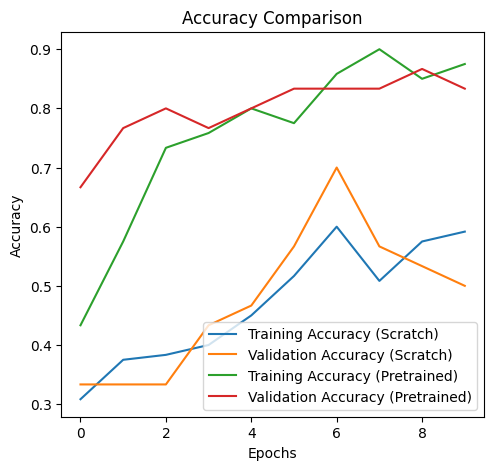

In [ ]:
#Accuration Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_scratch.history['accuracy'], label='Training Accuracy (Scratch)')
plt.plot(history_scratch.history['val_accuracy'], label='Validation Accuracy (Scratch)')
plt.plot(history_pretrained.history['accuracy'], label='Training Accuracy (Pretrained)')
plt.plot(history_pretrained.history['val_accuracy'], label='Validation Accuracy (Pretrained)')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

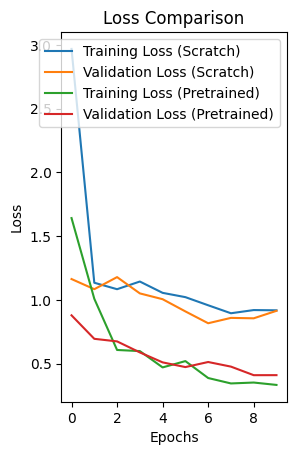

In [ ]:
#Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_scratch.history['loss'], label='Training Loss (Scratch)')
plt.plot(history_scratch.history['val_loss'], label='Validation Loss (Scratch)')
plt.plot(history_pretrained.history['loss'], label='Training Loss (Pretrained)')
plt.plot(history_pretrained.history['val_loss'], label='Validation Loss (Pretrained)')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Scratch Model Prediction:
1/1 [==============================] - 1s 825ms/step


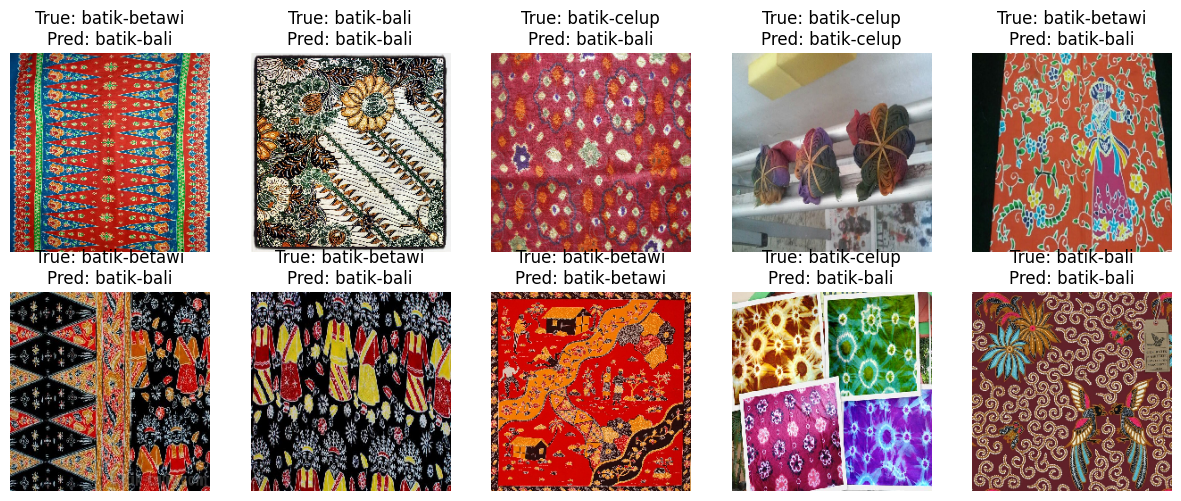

Pretrained Model Prediction (MobileNetV2):
1/1 [==============================] - 2s 2s/step


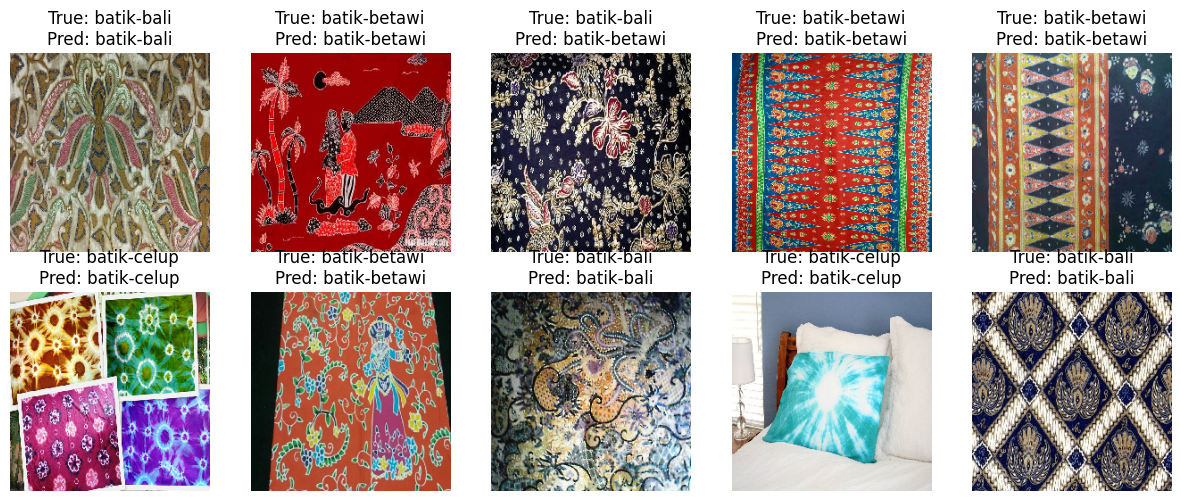

In [ ]:
# Fungsi untuk menampilkan hasil prediksi
def display_predictions(model, validation_generator, class_indices, num_images=10):
    # Mengambil batch pertama dari data validasi
    x_val, y_val = next(validation_generator)

    # Melakukan prediksi
    y_pred = model.predict(x_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    # Mapping class indices ke nama kelas
    class_names = {v: k for k, v in class_indices.items()}

    # Menampilkan hasil prediksi
    plt.figure(figsize=(15, 15))
    for i in range(min(num_images, len(x_val))):
        plt.subplot(5, 5, i + 1)
        plt.imshow(x_val[i])
        plt.title(f"True: {class_names[y_true_classes[i]]}\nPred: {class_names[y_pred_classes[i]]}")
        plt.axis('off')
    plt.show()

# Menampilkan hasil prediksi untuk model dari scratch
print("Scratch Model Prediction:")
display_predictions(scratch_model, validation_generator, train_generator.class_indices)

# Menampilkan hasil prediksi untuk model pretrained
print("Pretrained Model Prediction (MobileNetV2):")
display_predictions(pretrained_model, validation_generator, train_generator.class_indices)

